In [1]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [3]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


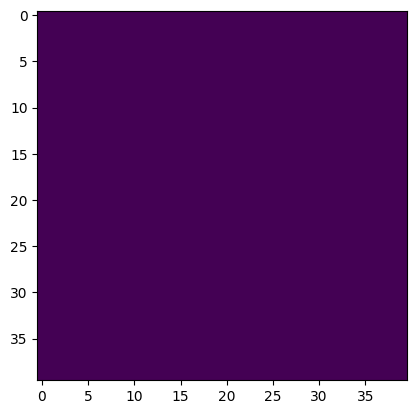

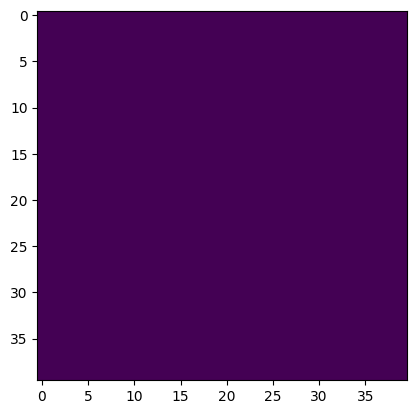

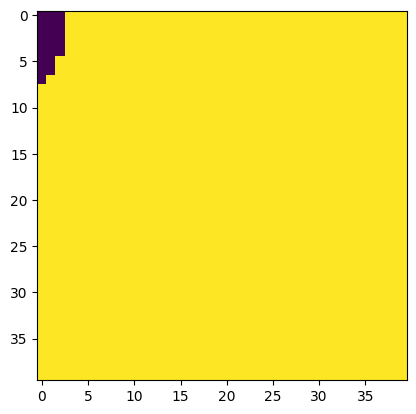

In [4]:
def sagital_adjacent_slices(img_n_mmni, m, epsilon, y_tuple, z_tuple):
    crop_img = img_n_mmni.slicer[m-epsilon:m+epsilon+1:epsilon, y_tuple[0]:y_tuple[1], z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (1, 2, 0))
    return crop_img

def coronal_adjacent_slices(img_n_mmni, x_tuple, m, epsilon, z_tuple):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], m-epsilon:m+epsilon+1:epsilon, z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (0, 2, 1))
    return crop_img

def axial_adjacent_slices(img_n_mmni, x_tuple, y_tuple, m, epsilon):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], y_tuple[0]:y_tuple[1], m-epsilon:m+epsilon+1:epsilon]
    return crop_img.get_fdata()

#Test of coronal projection
img_data = coronal_adjacent_slices(img_n_mmni, (40,80), 110, 5,(40,80))
#img_data = coronal_adjacent_slices(img_n_mmni, (0,181), 110, 5,(0,181))
img_data = coronal_adjacent_slices(img_n_mmni, (100,140), 110, 5,(40,80))


for i in range(3):
    plt.imshow(img_data[:, :, i])
    plt.show()

In [5]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head(7)


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [6]:
print(y_data.shape)

(420, 2)


In [7]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
        
            
            for i in range(-3,3):
                img_3_projections = []
                img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
            
            
            for i in range(-3,3):
                img_3_projections = []

                img_slices_data = sagital_adjacent_slices(img_n_mmni, 120+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_slices_data = img_slices_data[:, :, ::-1]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (100+i,140+i), 110+i, epsilon, (30+i,70+i))
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni,(100+i,140+i), (90+i,130+i), 60+i, epsilon)
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
        
    X_data = np.array(X_data)   
    return X_data, Y_data


2022-12-16 16:27:25.107777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 16:27:26.284470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-16 16:27:26.284560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-16 16:27:26.284567: W tensorflow/compiler/tf

In [8]:
X_data, Y_data = Data_preparation(y_data, epsilon = 4) 
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(5028, 3, 40, 40, 3)
5028


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=49) 

print("len(X_train) = ", len(X_train))
print("len(X_test) = ", len(X_test))

len(X_train) =  4022
len(X_test) =  1006


In [10]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def Slices_network(inputs, i, padding='same'):
    x = inputs[:,i,:,:]
    num_filters = 32

    x = SeparableConv2D(filters=num_filters, kernel_size=(4,4), strides=1, padding=padding)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    
    num_filters *= 2
    x = SeparableConv2D(filters=num_filters, kernel_size=(2,2), strides=1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(Slices_network(inputs=inputs, i=i, padding='same'))

    x = Concatenate(name = "Concat1")(out_list)
    x = Flatten(name = "Flatten1")(x)
    
    outputs = Dense(nb_class, activation='softmax')(x)
    
    return Model(inputs, outputs)

    
model = create_model_2D_epsilon(X_train[0].shape)
model.summary()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
     

    

2022-12-16 16:39:31.915716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 16:39:31.935145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 16:39:31.935271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 16:39:31.935809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 40, 40, 3)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 40, 40, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [11]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), callbacks=[callback])

Epoch 1/50


2022-12-16 16:39:34.532719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-16 16:39:35.366300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-16 16:39:35.991882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-16 16:39:36.105564: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8efd1e4490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-16 16:39:36.105584: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2022-12-16 16:39:36.118314: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:

121/126 [===========================>..] - ETA: 0s - loss: 0.5975 - accuracy: 0.7195

2022-12-16 16:39:40.380295: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


126/126 [==============================] - 7s 19ms/step - loss: 0.5915 - accuracy: 0.7238 - val_loss: 0.6118 - val_accuracy: 0.7256
Epoch 2/50
126/126 [==============================] - 1s 10ms/step - loss: 0.4681 - accuracy: 0.7944 - val_loss: 0.5247 - val_accuracy: 0.7813
Epoch 3/50
126/126 [==============================] - 1s 10ms/step - loss: 0.4237 - accuracy: 0.8210 - val_loss: 0.4644 - val_accuracy: 0.8022
Epoch 4/50
126/126 [==============================] - 1s 10ms/step - loss: 0.3984 - accuracy: 0.8334 - val_loss: 0.4013 - val_accuracy: 0.8350
Epoch 5/50
126/126 [==============================] - 1s 10ms/step - loss: 0.3710 - accuracy: 0.8481 - val_loss: 0.3916 - val_accuracy: 0.8300
Epoch 6/50
126/126 [==============================] - 1s 10ms/step - loss: 0.3595 - accuracy: 0.8528 - val_loss: 0.3769 - val_accuracy: 0.8429
Epoch 7/50
126/126 [==============================] - 1s 10ms/step - loss: 0.3355 - accuracy: 0.8662 - val_loss: 0.3837 - val_accuracy: 0.8320
Epoch 8/50

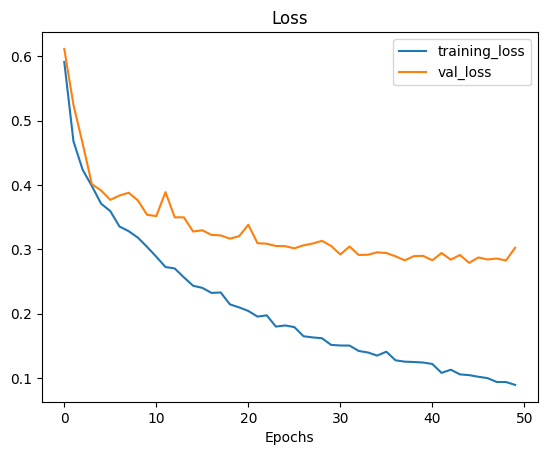

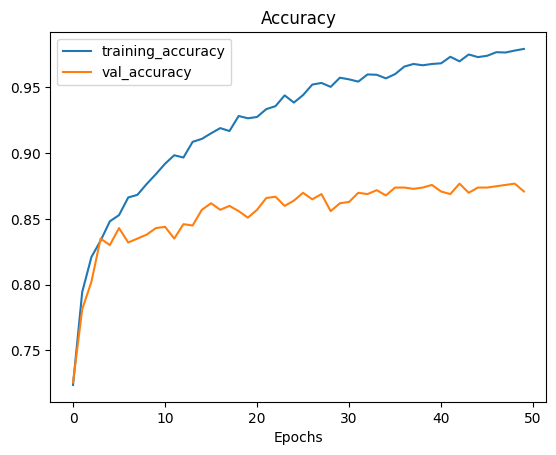

In [12]:
def plot_loss_curves(history):
      
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      accuracy = history.history['accuracy']
      val_accuracy = history.history['val_accuracy']

      epochs = range(len(history.history['loss']))

      # Plot loss
      plt.plot(epochs, loss, label='training_loss')
      plt.plot(epochs, val_loss, label='val_loss')
      plt.title('Loss')
      plt.xlabel('Epochs')
      plt.legend()

      # Plot accuracy
      plt.figure()
      plt.plot(epochs, accuracy, label='training_accuracy')
      plt.plot(epochs, val_accuracy, label='val_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()

plot_loss_curves(history)

32/32 [==============================] - 0s 2ms/step
[[519  34]
 [ 96 357]]


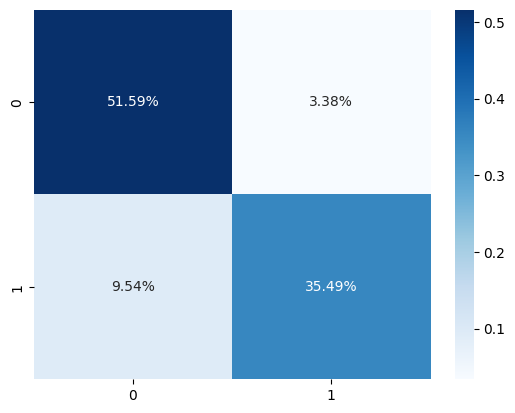

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

labels = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(labels, pred)
print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()


## Training with whole AD and CN data for MCI 


In [14]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def Slices_network(inputs, i, padding='same'):
    x = inputs[:,i,:,:]
    num_filters = 32
    print(x.shape)
    x = SeparableConv2D(filters=num_filters, kernel_size=(4,4), strides=1, padding=padding)(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    print(x.shape)
    x = Activation('relu')(x)
    
    num_filters *= 2
    x = SeparableConv2D(filters=num_filters, kernel_size=(2,2), strides=1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(Slices_network(inputs=inputs, i=i, padding='same'))

    print("iiiii")
    x = Concatenate(name = "Concat1")(out_list)
    print(x.shape)
    x = Flatten(name = "Flatten1")(x)
    print(x.shape)
    outputs = Dense(nb_class, activation='softmax')(x)
    print(outputs.shape)
    return Model(inputs, outputs)

    
model2 = create_model_2D_epsilon(X_train[0].shape)
model2.summary()
model2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
     

(None, 40, 40, 3)
(None, 40, 40, 32)
(None, 40, 40, 32)
(None, 20, 20, 32)
(None, 40, 40, 3)
(None, 40, 40, 32)
(None, 40, 40, 32)
(None, 20, 20, 32)
(None, 40, 40, 3)
(None, 40, 40, 32)
(None, 40, 40, 32)
(None, 20, 20, 32)
iiiii
(None, 19200)
(None, 19200)
(None, 2)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 40, 40, 3)   0           ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                     

In [15]:
#history2 = model2.fit(X_data, Y_data, epochs=30)

In [16]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data

In [17]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data_MCI = get_data_MCI(path)
y_data_MCI.head()
print(y_data_MCI.shape)

(300, 3)


In [18]:
from tensorflow.keras.utils import to_categorical


def Data_preparation_MCI(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
        
            
            for i in range(-3,3):
                img_3_projections = []
                img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                    Y_data.append(1)
                elif Y['Conversion'][index] == 4 : #sMCI
                    Y_data.append(0)    

            
            for i in range(-3,3):
                img_3_projections = []

                img_slices_data = sagital_adjacent_slices(img_n_mmni, 120+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_slices_data = img_slices_data[:, :, ::-1]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (100+i,140+i), 110+i, epsilon, (30+i,70+i))
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni,(100+i,140+i), (90+i,130+i), 60+i, epsilon)
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                    Y_data.append(1)
                elif Y['Conversion'][index] == 4 : #sMCI
                    Y_data.append(0)    
        
    X_data = np.array(X_data)   
    return X_data, Y_data


In [19]:
X_data_MCI, Y_data_MCI = Data_preparation_MCI(y_data_MCI,  epsilon = 4) 
Y_data_MCI = to_categorical(Y_data_MCI, num_classes=2)

print(X_data_MCI.shape)
print(len(Y_data_MCI))

(3600, 3, 40, 40, 3)
3600


In [20]:
# on garde seulement une colonne pour y 
y_data_MCI = np.argmax(Y_data_MCI, axis= 1)

In [21]:
ypred_model2 = model.predict(X_data_MCI)

113/113 [==============================] - 0s 2ms/step


In [22]:
ypred_model2 = np.where(ypred_model2 > 0.5, 1, 0)

In [23]:
from sklearn.metrics import accuracy_score
ypred_model2 = np.argmax(ypred_model2, axis= 1)

acc_model2 = accuracy_score(ypred_model2, y_data_MCI)

print('accuracy on MCI data based on CN and AD training: {} '.format(acc_model2))

accuracy on MCI data based on CN and AD training: 0.6163888888888889 


[[1121  427]
 [ 954 1098]]


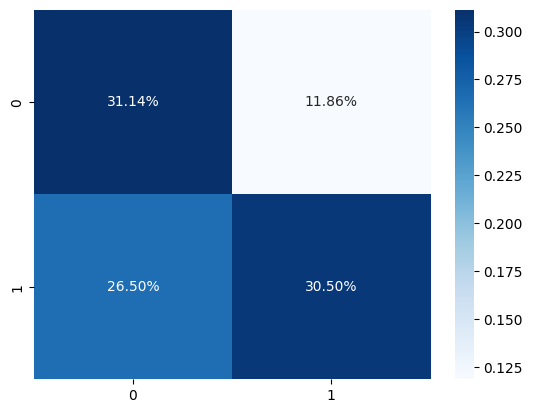

In [24]:

cf_matrix = confusion_matrix(y_data_MCI, ypred_model2)
print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()
